# Load libraries

In [51]:
# general
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from prettytable import PrettyTable
from pathlib import Path
import os
import random
import time
import warnings
warnings.filterwarnings("ignore")

# pytorch
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101

# l5kit
import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI
print(l5kit.__version__)

# others
from utilities import save_yaml
from models.loss import pytorch_neg_multi_log_likelihood_batch
from models.baseline import Baseline_Model
from models.cnn_gru_decoder import CNN_GRU_Decoder


# set random seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

1.5.0


# Set configuration

In [52]:
cfg = {
    'format_version': 4,
    'data_path': '/home/mmv664/Documents/motion_prediction/data',
    'output_path' : '/home/mmv664/Documents/motion_prediction/motion_prediction/results/cnn_gru_decoder',
    'device': 'cuda:2',
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'step_time': 0.1,
        'render_ego_history': True,
        'lr': 1e-4,
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,
        'set_origin_to_bottom': True,
        'filter_agents_threshold': 0.5,
        'disable_traffic_light_faces': False,
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 4
    },
    
    'valid_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },

    'train_params': {
        'epochs': 10,
    }
}

In [53]:
out_dir = Path(cfg['output_path'])
os.makedirs(str(out_dir), exist_ok=True)
save_yaml(out_dir / 'cfg.yaml', cfg)
device =  torch.device(cfg['device'])

# Load data

In [54]:
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

## Training database

In [5]:
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


## Validation database

In [6]:
valid_cfg = cfg["valid_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
valid_zarr = ChunkedDataset(dm.require(valid_cfg["key"])).open()
valid_dataset = AgentDataset(cfg, valid_zarr, rasterizer)
valid_dataloader = DataLoader(valid_dataset, shuffle=valid_cfg["shuffle"], batch_size=valid_cfg["batch_size"], 
                             num_workers=valid_cfg["num_workers"])
print(valid_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


# Data visualization and exploration

In [55]:
def visualize_trajectory(dataset, index, title="target_positions movement with draw_trajectory"):
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])

    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

In [8]:
print(len(train_dataset))

22496709


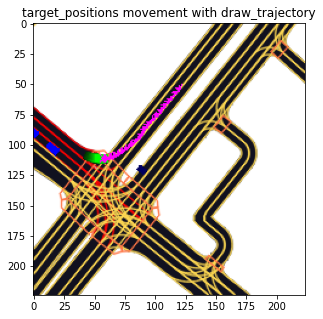

In [9]:
plt.figure(figsize = (5,5))
visualize_trajectory(train_dataset, index=1000)

In [ ]:
# alternative plotting injupyter notebook
output_notebook()
mapAPI = MapAPI.from_cfg(dm, cfg)
scene_idx = 0
out = zarr_to_visualizer_scene(train_zarr.get_scene_dataset(scene_idx), mapAPI)
out_vis = visualize(scene_idx, out)
show(out_vis)

# Load model

In [56]:
# select a model
model = Baseline_Model(cfg)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])

In [57]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds, confidences

# Train

In [58]:
losses = []
val_losses = []
times = []
epochs = []

start = time.time()
for epoch in range(cfg["train_params"]["epochs"]):
    train_loss = 0.0
    model.train()
    torch.set_grad_enabled(True)
    iteration = 0
    for data in tqdm(train_dataloader):
        loss, _, _ = forward(data, model, device)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        iteration += 1
        if iteration > 10000:
            break
    
    val_loss = 0.0
    model.eval()
    torch.set_grad_enabled(False)
    val_iteration = 0
    for data in valid_dataloader:
        v_loss, _, _ = forward(data, model, device)
        val_loss += v_loss.item()
        
        val_iteration += 1
        if val_iteration > 2000:
            break
        
    torch.save(model.state_dict(), f'{cfg["output_path"]}/model_{epoch}.pth')
        
    epochs.append(epoch)
    times.append((time.time()-start)/60)
    losses.append(train_loss / iteration)
    val_losses.append(val_loss/ val_iteration)
    
    print(f'Epoch {epoch+1} \t Training Loss: {losses[-1]} \t Validation Loss: {val_losses[-1]}')

    
results = pd.DataFrame({'epochs': epochs, 'loss': losses, 'val_loss': val_losses, 'elapsed_time (mins)': times})
results.to_csv(f'{cfg["output_path"]}/train_results.csv', index = False)

  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 81.39763983913976 		 Validation Loss: 47.53067510223192


  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 2 		 Training Loss: 38.164646734894305 		 Validation Loss: 38.25588912307157


  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 3 		 Training Loss: 29.96018368069523 		 Validation Loss: 27.365149067116967


  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 4 		 Training Loss: 26.384689185991487 		 Validation Loss: 24.472804606181924


  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 5 		 Training Loss: 23.65211648479031 		 Validation Loss: 22.605498829480915


  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 6 		 Training Loss: 22.031409044931344 		 Validation Loss: 22.59555911585695


  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 7 		 Training Loss: 20.87856887145205 		 Validation Loss: 19.768320233726325


  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 8 		 Training Loss: 19.67281299654859 		 Validation Loss: 24.362676558928143


  0%|          | 0/703023 [00:00<?, ?it/s]

Epoch 9 		 Training Loss: 18.9988080571263 		 Validation Loss: 19.515567168977153


  1%|▏         | 10000/703023 [36:11<41:48:35,  4.60it/s]


Epoch 10 		 Training Loss: 18.40599474443482 		 Validation Loss: 17.393854622862236


# Visualize results

## single agent

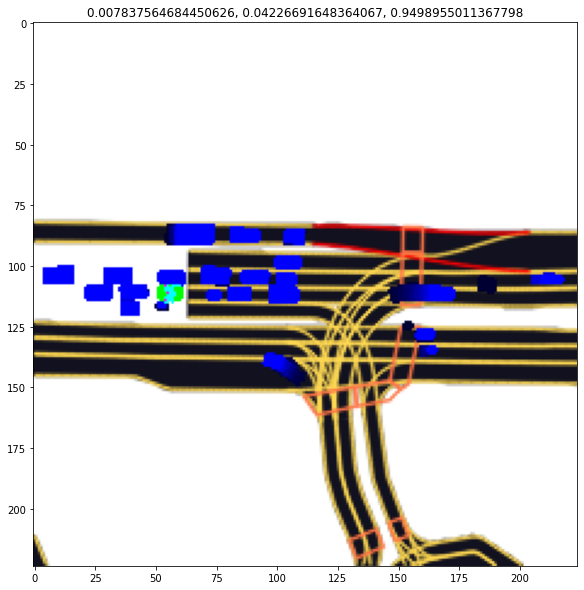

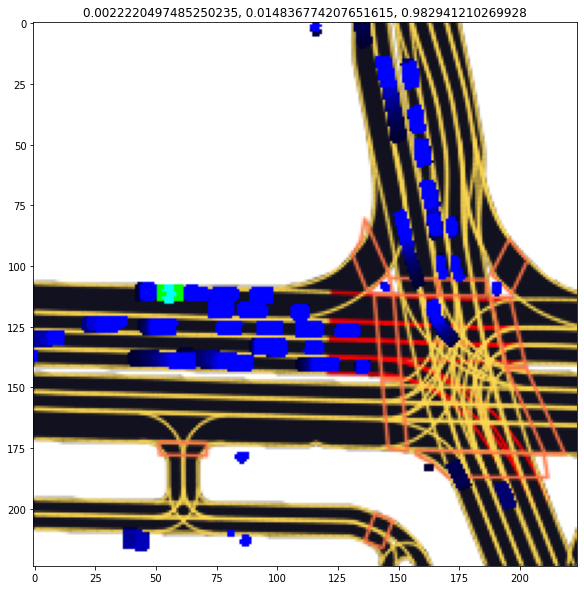

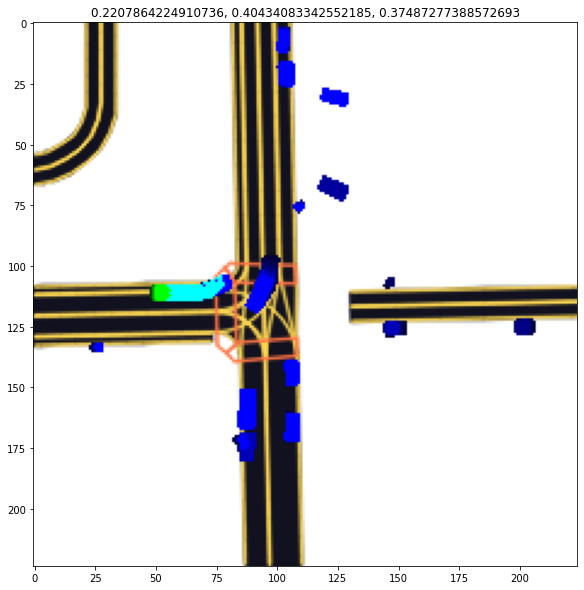

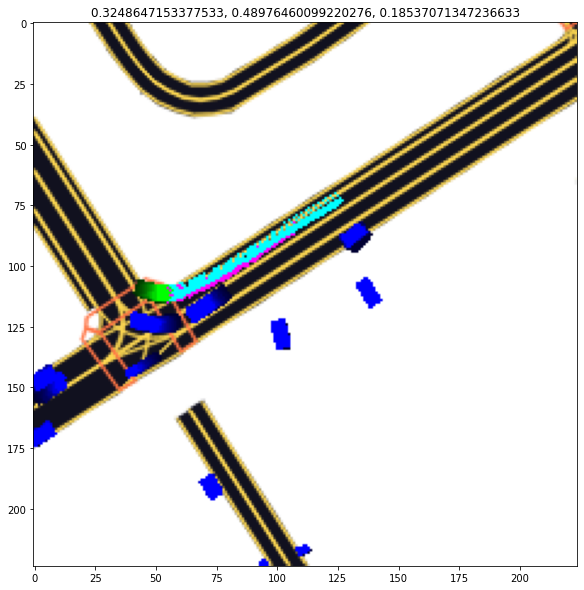

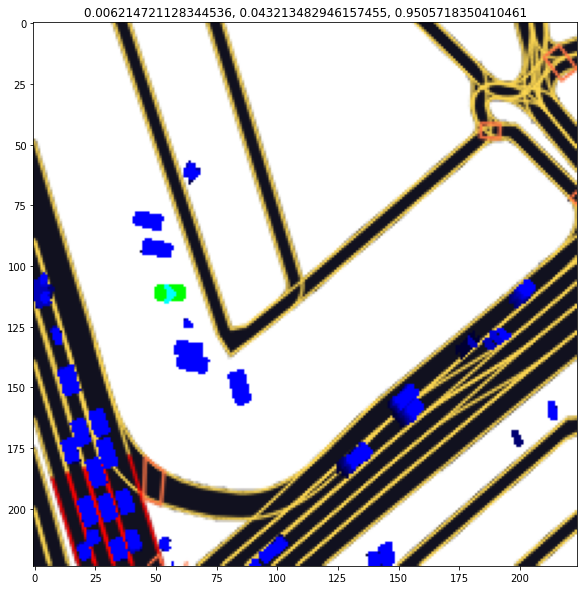

In [50]:
dataset = valid_dataset
index = random.sample(range(0,len(dataset)), 5) #[1000]

for ind in index:
    plt.figure(figsize = (10,10))

    data = dataset[ind]

    preds, confidences = model(torch.from_numpy(data["image"]).unsqueeze(0).to(device))
    out_pos = preds[0].detach().cpu().numpy()
    out_pos = transform_points(out_pos, data["raster_from_agent"])
    out_conf = confidences[0].detach().cpu().numpy()

    ind = np.argmax(out_conf)


    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])

    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])


    draw_trajectory(im, out_pos[ind], (0, 255, 255), yaws=data["target_yaws"])
    # draw_trajectory(im, out_pos[1], (0, 125, 125), yaws=data["target_yaws"])
    # draw_trajectory(im, out_pos[2], (125, 0, 125), yaws=data["target_yaws"])

    title = '{}, {}, {}'.format(out_conf[0], out_conf[1], out_conf[2])

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

## All agents in a scene

In [ ]:
dm = LocalDataManager(None)
loader_cfg = cfg["valid_data_loader"]
zarr_path = dm.require(loader_cfg["key"])
num_frames_to_chop =100
eval_base_path = os.path.splitext(zarr_path)[0] + "_chopped_{}".format(num_frames_to_chop)

if not os.path.exists(eval_base_path):
    eval_base_path = create_chopped_dataset(zarr_path,
                                            cfg["raster_params"]["filter_agents_threshold"],
                                            num_frames_to_chop,
                                            cfg["model_params"]["future_num_frames"],
                                            min_frame_future=10)

eval_zarr_path = os.path.join(eval_base_path, os.path.basename(zarr_path))
eval_mask_path = os.path.join(eval_base_path, "mask.npz")
zarr = ChunkedDataset(eval_zarr_path).open()
agents_mask = np.load(eval_mask_path)["arr_0"]

rasterizer = build_rasterizer(cfg, dm)
vis_dataset = AgentDataset(cfg, zarr, rasterizer, agents_mask=agents_mask)
vis_base_path = os.path.splitext(zarr_path)[0] + "_chopped_{}".format(num_frames_to_chop)
vis_gt_path = os.path.join(vis_base_path, "gt.csv")

rasterizer = build_rasterizer(cfg, dm)
vis_ego_dataset = EgoDataset(cfg, vis_dataset.dataset, rasterizer)

In [ ]:
# adapted based on: https://github.com/aaronzguan/Motion-Prediction-for-Autonomous-Vehicle/blob/main/validate.py
def visualize_all_agents(model, eval_gt_path, eval_dataset, eval_ego_dataset, save = False):
    """
    Visualize prediction results　from the ego (AV) point of view for those frames of interest
    """
    model.eval()

    # build a dict to retrieve future trajectories from GT
    gt_rows = {}
    for row in read_gt_csv(eval_gt_path):
        gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

    # randomly pick some frames for visualization
    num_frames = 1000
    random_frames = np.random.randint(99, len(eval_ego_dataset) - 1, num_frames)

    for frame_number in random_frames:
        agent_indices = eval_dataset.get_frame_indices(frame_number)
        if not len(agent_indices):
            continue
        # get AV point-of-view frame
        data_ego = eval_ego_dataset[frame_number]

        predicted_positions_1 = []
        predicted_positions_2 = []
        predicted_positions_3 = []
        target_positions = []

        for v_index in agent_indices:
            data_agent = eval_dataset[v_index]
            
            preds, confidences = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
            out_pos = preds[0].detach().cpu().numpy()
            out_conf = confidences[0].detach().cpu().numpy()
            
            sorted_inds = out_conf.argsort()
            out_conf_sorted = out_conf[sorted_inds[::-1]]
            out_pos_sorted = out_pos[sorted_inds[::-1]]
            
            
            # store absolute world coordinates
            predicted_positions_1.append(transform_points(out_pos_sorted[0], data_agent["world_from_agent"]))
            predicted_positions_2.append(transform_points(out_pos_sorted[1], data_agent["world_from_agent"]))
            predicted_positions_3.append(transform_points(out_pos_sorted[2], data_agent["world_from_agent"]))
            # retrieve target positions from the GT and store as absolute coordinates
            track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
            target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])

        # convert coordinates to AV point-of-view so we can draw them
        predicted_positions_1 = transform_points(np.concatenate(predicted_positions_1), data_ego["raster_from_world"])
        predicted_positions_2 = transform_points(np.concatenate(predicted_positions_2), data_ego["raster_from_world"])
        predicted_positions_3 = transform_points(np.concatenate(predicted_positions_3), data_ego["raster_from_world"])
        target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])
        
        fig, axs = plt.subplots(1,4, figsize = (16,4))
        
        im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
        draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
        axs[0].set_title("ground truth for sample {}".format(frame_number))
        axs[0].imshow(im_ego)
        
        im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
        draw_trajectory(im_ego, predicted_positions_1, PREDICTED_POINTS_COLOR)
        axs[1].set_title("most confident")
        axs[1].imshow(im_ego)
        
        im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
        draw_trajectory(im_ego, predicted_positions_2, PREDICTED_POINTS_COLOR)
        axs[2].set_title("second confident".format(out_conf_sorted[1]))
        axs[2].imshow(im_ego)
        
        im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
        draw_trajectory(im_ego, predicted_positions_3, PREDICTED_POINTS_COLOR)
        axs[3].set_title("third confident".format(out_conf_sorted[2]))
        axs[3].imshow(im_ego)
        
        plt.show()

        if save:
            plt.savefig("./frame_" + str(frame_number) + ".png")

In [ ]:
visualize_all_agents(model, vis_gt_path, vis_dataset, vis_ego_dataset)